In [11]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import math
import hashlib
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import svm,linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel,RFE,RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler,KBinsDiscretizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR,LinearSVR
from sklearn import model_selection
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from numpy import transpose
from collections.abc import Iterable
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import os


In [12]:
#Put in fname the csv file of the molecular descriptors calculated for each molecule

fname = "../3_train_test_split/train_set.csv"
df = pd.read_csv("../3_train_test_split/train_set.csv")

column_names = df.columns
column_names

Index(['PMI1', 'PMI2', 'PMI3', 'Asphericity', 'Eccentricity',
       'InertialShapeFactor', 'NPR1', 'NPR2', 'PBF', 'RadiusOfGyration',
       ...
       'HDonors', 'heteroatoms', 'rotatableBonds', 'saturatedCarbocycles',
       'saturatedHeterocycles', 'satureatedRings', 'ringCount', 'molLogP',
       'molMR', '-logIC50'],
      dtype='object', length=1010)

In [13]:
X = df.drop(columns=['-logIC50'])  # Features
y = df['-logIC50']                 # Target variable

In [15]:
#Use RFECV from sklearn to model

model = RandomForestRegressor(n_estimators=50, random_state=42)
rfecv = RFECV(
    estimator=model, 
    step=20, 
    cv=KFold(5),  # 5-fold cross-validation
    scoring='neg_mean_squared_error'  # Use neg_mean_squared_error for regression
)

# Step 3: Fit the RFECV to the training data
rfecv.fit(X, y)

# Display the optimal number of features
print("Optimal number of features:", rfecv.n_features_)


Optimal number of features: 9


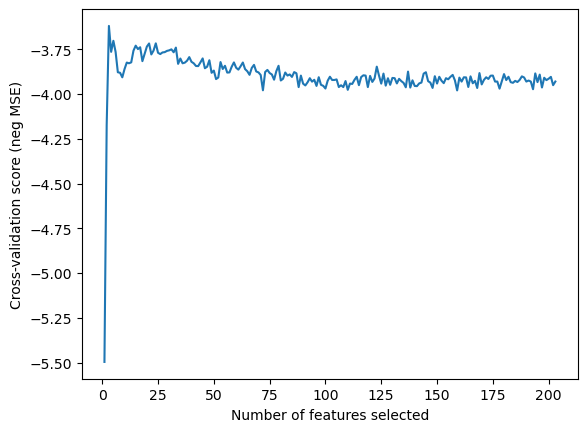

The peak cross-validation score is: -3.6204135430517574


In [ ]:
# Plot number of features VS. cross-validation scores

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (neg MSE)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

# Get the peak score
peak_score = max(rfecv.cv_results_['mean_test_score'])

# Print the peak score
print(f"The peak cross-validation score is: {peak_score}")

#n_estimator = 100, step = 5, -3.5811981127254384
#n_estimator = 100, step = 10, -3.5811981127254384
    #features = 'MORSE_205', 'RDF_31', 'AUTOCORR3D_7', 'AUTOCORR3D_57', 'GGI6', 'GGI7', 'GGI9', 'qed', 'molLogP'
#n_estimator = 50, step = 10, -3.643786309125889
#n_estimator = 100, step = 20, -3.7218224693225865
#n_estimator = 40, step = 20, -3.677299349872603
#n_estimator = 60, step = 20, -3.6431093541780415
#n_estimator = 40, step = 10, -3.7141160263546285
#n_estimator = 50, step = 5, -3.6204135430517574
#n_estimator = 50, step = 20, -3.564713391615207
    #'GETAWAY_246', 'MORSE_205', 'RDF_31', 'AUTOCORR3D_7', 'AUTOCORR3D_57', 'GGI6', 'GGI7', 'qed', 'molLogP'
    #Chose this set of parameters since it has the highest cross validation score

In [33]:
feature_names = X.columns

# Get the mask of selected features
selected_mask = rfecv.support_

# Retrieve the names of selected features
selected_features = feature_names[selected_mask]
print(f"Selected features: {list(selected_features)}")

#n_estimator = 50, step = 20, -3.564713391615207
    #'GETAWAY_246', 'MORSE_205', 'RDF_31', 'AUTOCORR3D_7', 'AUTOCORR3D_57', 'GGI6', 'GGI7', 'qed', 'molLogP'

Selected features: ['GETAWAY_246', 'MORSE_205', 'RDF_31', 'AUTOCORR3D_7', 'AUTOCORR3D_57', 'GGI6', 'GGI7', 'qed', 'molLogP']


In [10]:
interaction_features = df

# Non-binders have the value of 10000 imputed, which corresponds to about -11.5 when taking -log(IC50).
# Create an is_imputed column that has 0 when the data is not imputed and 1 when it is. 
threshold = 1e-6  # Tolerance for floating-point comparison
df['is_imputed'] = (np.abs(df['-logIC50'] - (-np.log(10000 * 1e-9)) ) < threshold).astype(int)
# Create interaction terms with the is_imputed column (multiply the descriptor columns with the is_imputed column)
X_interactions = df.multiply(df['is_imputed'], axis=0)
X_interactions.columns = [f"{col}_is_imputed" for col in interaction_features] # Rename the columns
# Combine original features, interaction terms, and target variable
X_reg_full = pd.concat([df, X_interactions], axis=1)

X_reg_full

,PMI1,PMI2,PMI3,Asphericity,Eccentricity,InertialShapeFactor,NPR1,NPR2,PBF,RadiusOfGyration,...,heteroatoms_is_imputed,rotatableBonds_is_imputed,saturatedCarbocycles_is_imputed,saturatedHeterocycles_is_imputed,satureatedRings_is_imputed,ringCount_is_imputed,molLogP_is_imputed,molMR_is_imputed,-logIC50_is_imputed,is_imputed_is_imputed
0,-1.546260,-0.743806,-0.940079,1.641074,1.109793,2.122319,-1.436069,0.750010,-2.099344,-0.481066,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0
1,0.943718,0.190366,0.158647,-0.746610,-0.409554,-0.554883,0.608355,0.318954,0.958848,-0.280803,...,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0
2,-0.014477,-1.034673,-1.014128,-1.216506,-1.702167,-0.446601,1.477181,-1.036407,0.922757,-1.160351,...,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0
3,-0.059084,0.466957,0.240280,0.215490,0.583326,-0.282053,-0.405386,1.125261,0.555007,0.082381,...,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0
4,1.768178,-0.400854,-0.287434,-1.503079,-3.186263,-0.679295,2.206794,-0.636300,1.176011,-0.518897,...,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,1.135397,0.142135,0.106743,-0.915201,-0.732521,-0.580421,0.856038,0.312951,0.779572,0.072683,...,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0
551,-0.592729,-0.755729,-0.997946,-0.519889,-0.119254,-0.017452,0.360263,1.091700,0.477809,-1.034829,...,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0
552,-0.681473,2.288760,2.007085,1.695538,1.117666,0.072578,-1.463680,1.317700,-0.337446,2.157554,...,0.991819,-0.619307,-0.374196,-0.315596,-0.499087,0.265767,-0.744726,0.258482,11.512925,1
553,-0.596877,-0.309465,-0.527212,0.134730,0.533427,-0.023281,-0.339053,1.003150,0.757913,-0.268286,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0
